In [ ]:
!pip install datashader

# Monte Carlo Model


In [8]:
#@title Generate anomalies
import matplotlib.pyplot as plt
import ipywidgets as widgets
import functools
import numpy as np
import anomalyDetClass

MONTECARLO = {
    'types': [True,True,True], #pulse,ramp,step
    'anomalies': np.array([]),
    'nA': 10000
}

def _generate_anomalies(_, nA, beta, T, types):   
  _nA = nA.value
  _beta = beta.value
  _T = T.value  
  _types = [t.value for t in types]

  #random generator: fixed state for reproducibility
  rs = np.random.RandomState(seed=(1,2,3)) 

  anomalies = anomalyDetClass.generate_anomalies(_nA,_beta,_T,_types,rs)
  MONTECARLO['anomalies'] = anomalies
  MONTECARLO['types'] = _types
  MONTECARLO['nA'] = int(_nA)

style = {
    'description_width': '30%',    
}

beta_slider = widgets.FloatRangeSlider(**{
    'min': 0.005,
    'max': 0.1,
    'value': (0.005,0.01),
    'step':0.001, 
    'readout_format':'.3f',       
    'description':'Magnitude (pu)  ±',
    'style': style,
    'layout':widgets.Layout(width='50%')
})

tempo_slider = widgets.IntRangeSlider(**{
    'min': 30,
    'max': 120,    
    'description':'Temporality (samples)',   
    'style': style,
    'value': (30,120),
    'layout':widgets.Layout(width='50%') 
})

pulse_checkbox = widgets.Checkbox(True,description='Pulse')
ramp_checkbox = widgets.Checkbox(True,description='Ramp')
step_checkbox = widgets.Checkbox(True,description='Step')

anomalies_button = widgets.Button(description='Create anomalies')

nA_widget = widgets.IntText(10000, description='Anomalies per class', style = {
    'description_width':'initial'
},
layout=widgets.Layout(width='200px',display="flex", justify_content="center") )
anomalies_box = widgets.VBox(children=[widgets.Label('Anomaly types',layout=widgets.Layout(display="flex", justify_content="center")), 
  nA_widget,
  widgets.HBox(children=[pulse_checkbox,ramp_checkbox,step_checkbox],layout=widgets.Layout(display="flex", justify_content="center"))])

anomalies_button.on_click(functools.partial(_generate_anomalies, nA=nA_widget,
beta=beta_slider, T=tempo_slider, types=anomalies_box.children[2].children)) 

display(beta_slider,tempo_slider,anomalies_box,
  widgets.HBox(children=[anomalies_button],
  layout=widgets.Layout(display='flex', flex_flow='column', align_items='center', width='100%')))

FloatRangeSlider(value=(0.005, 0.01), description='Magnitude (pu)  ±', layout=Layout(width='50%'), max=0.1, mi…

IntRangeSlider(value=(30, 120), description='Temporality (samples)', layout=Layout(width='50%'), max=120, min=…

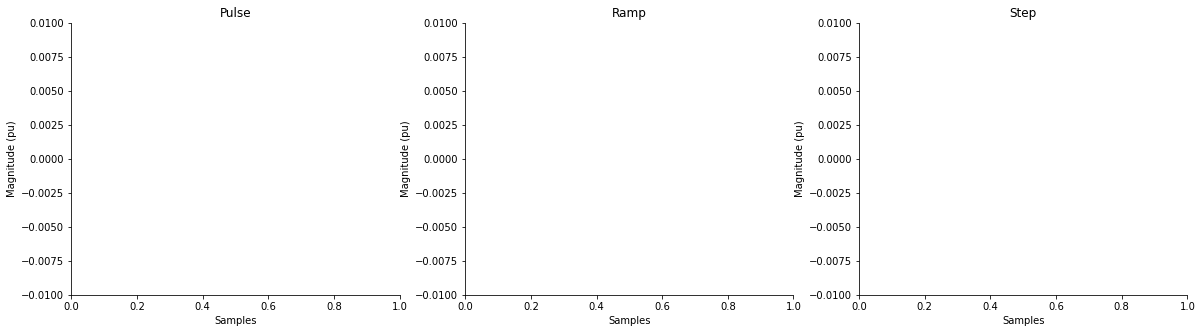

In [9]:
#@title Preview first 1k anomalies
nA = MONTECARLO['nA']
anomalies = MONTECARLO['anomalies']
titles = ['Pulse', 'Ramp', 'Step']
titles = [titles[i] for i in range(3) if MONTECARLO['types'][i] ]
plt.figure(figsize=(20,5))
for i in range(len(titles)):      
  plt.subplot(1, len(titles), i+1)
  j = nA * i #offset
  plt.title(titles[i])
  plt.gca().spines["right"].set_visible(False)
  plt.gca().spines["top"].set_visible(False)  
  [plt.plot(anomaly) for anomaly in anomalies[j:j + np.min((nA,1000))]]   
  plt.xlabel('Samples')
  plt.ylabel('Magnitude (pu)')
  plt.ylim((-beta_slider.value[-1],beta_slider.value[-1]))

In [11]:
import plotly.graph_objects as go

nA = MONTECARLO['nA']
anomalies = MONTECARLO['anomalies']
wS = 60
types = [i for i in range(3) if MONTECARLO['types'][i]]

def generate_signal(anomalies, wS, nA, types):  
  anomalies_len = np.sum( [anomaly.shape[0] for anomaly in anomalies] )
  w_middle =  (anomalies.shape[0] + 1) * 2 * wS #avoid anomalies collision   
  signal = np.ones(int(anomalies_len + w_middle))  
  offset = np.zeros(1)
  
  def add_anomaly(anomaly, i, signal, type, offset):
    alen = int(anomaly.shape[0])
    i0 = int(offset[0] +  2 * wS)        
    signal[i0:i0+alen] += anomaly
    if type:
      signal[i0+alen:] += anomaly[-1]
    offset[0] = i0 + alen
  [add_anomaly(anomalies[i],i,signal, types[int(i/nA)],offset) for i in range(MONTECARLO['anomalies'].shape[0])]    
  return signal

signal = generate_signal(anomalies, wS, nA, types)
signal = anomalyDetClass.awgn(signal,60,rs=np.random)

In [12]:
import datashader as ds

ModuleNotFoundError: ignored

In [36]:
fig = go.Figure(layout_template="none")

x = np.arange(int(1000))
y = signal[x]
fig.add_scattergl(x=x, y=y, mode='lines')
fig.update_layout(
    xaxis_title="Samples",
    yaxis_title="Voltage (pu)",
    xaxis=dict(
    autorange=True,
    range=[0, 1000],
    rangeslider=dict(
        autorange=True,
        range=[0, int(1000)]
    ),
    type="date"
    )
)

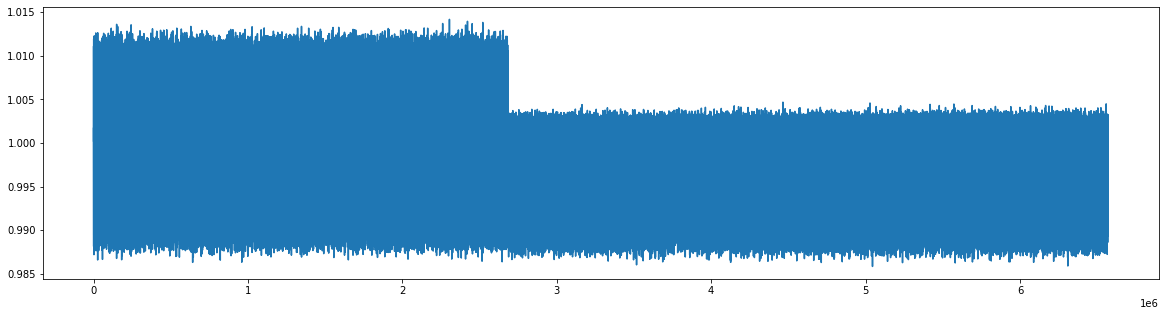

In [20]:
plt.figure(figsize=(20,5))
plt.plot(signal)